In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/groups/earlew/ejdawson/idealized_channel_demo/run_config

/home/groups/earlew/ejdawson/idealized_channel_demo/run_config


In [3]:
!ls ../main_scripts

build_domain_funcs.py  __pycache__	      run_config_funcs.py
helper_functions.py    quick_plot_funcs.py    run_ctrl_funcs_xx.py
old_scripts	       run_analysis_funcs.py  run_utils.py


In [1]:
import os
import numpy as np
import matplotlib.pylab as plt
import pickle
import importlib
import shutil

from scipy.interpolate import make_interp_spline

import sys
sys.path.insert(0,'/home/groups/earlew/ejdawson/idealized_channel_demo/main_scripts')

from main_scipts import build_domain_funcs as build_domain 
import run_config_funcs as rcf # import helpter functions

ModuleNotFoundError: No module named 'main_scipts'

## Gather work environment info

In [5]:
%env GROUP_SCRATCH=/scratch/groups/earlew
%env GROUP_HOME=/home/groups/earlew

env: GROUP_SCRATCH=/scratch/groups/earlew
env: GROUP_HOME=/home/groups/earlew


In [6]:
!echo $GROUP_HOME

/home/groups/earlew


In [7]:
print(os.environ['OAK'])
print(os.environ['SCRATCH'])
print(os.environ['HOME'])
print(os.environ['GROUP_SCRATCH']) 
print(os.environ['GROUP_HOME'])

/oak/stanford/schools/ees
/scratch/users/ejdawson
/home/users/ejdawson
/scratch/groups/earlew
/home/groups/earlew


In [8]:
group_scratch_dir = os.environ['GROUP_SCRATCH'] 
group_home_dir = os.environ['GROUP_HOME'] # recommended location to store  code 

# oak_dir = os.environ['OAK'] # we don't use OAK here, but this file system is for long term storage
# home_dir = os.environ['HOME'] # another option for storing personal code
pwd = os.getcwd()

Notes: 

+ Everyone in our group has access to files stored in `$GROUP_SCRATCH` and `$GROUP_HOME`. 
+ Files are purged from the scratch filesystem 90 days after they are last modified.
+ Use your home directory to store small files (e.g., code) that you wish to keep long term.
+ Copy files to OAK for long term storage

In [9]:
SUNet_ID = os.environ['HOME'].split('/')[-1]
print("SUNet_ID: %s" %SUNet_ID)
email = '%s@stanford.edu' %SUNet_ID

SUNet_ID: ejdawson


## Main run configuration

In [10]:
# set high level run configurations

run_config = {}
run_config['ncpus_xy'] = [25, 10] # cpu distribution in the x and y directions
run_config['run_name'] = 'shelf_channel_500_250_10km'
run_config['nyrs'] = 6 # simulaton time (years)
run_config['test'] = False # if True, run_config['nyrs'] will be shortened to a few time steps

run_config['horiz_res_km'] = 10 # horizontal grid spacing (km)
run_config['Lx_km'] = 4000 # domain size in x (m)
run_config['Ly_km'] = 1500 # domain size in y (m)
# NOTE: the number of grid points in x and y should be multiples of the number of cpus.

run_config['evolve_salt'] = False
run_config['use_GMRedi'] = False # should be set to false for eddy permitting resolutions
run_config['periodic_forcing'] = False # note: the code is not yet set up to handle time-dependent forcing

MITgcm_release = 'MITgcm-checkpoint67g' #mid-2019 release (have not tested other versions)
MITgcm_code_dir = os.path.join(group_home_dir, 'shared/mitgcm_releases', MITgcm_release)

# you probably don't need to touch this
run_config['use_MPI'] = True # for multi-processing
run_config['lf'] = '\r\n' # linebreak characters 
run_config['exps_dir'] = os.path.join(group_scratch_dir, '%s/research/modeling/MITgcm_PG/experiments' %SUNet_ID) 
run_config['run_dir'] = os.path.join(run_config['exps_dir'], run_config['run_name'])

In [11]:
run_config

{'Lx_km': 4000,
 'Ly_km': 1500,
 'evolve_salt': False,
 'exps_dir': '/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments',
 'horiz_res_km': 10,
 'lf': '\r\n',
 'ncpus_xy': [25, 10],
 'nyrs': 6,
 'periodic_forcing': False,
 'run_dir': '/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments/shelf_channel_500_250_10km',
 'run_name': 'shelf_channel_500_250_10km',
 'test': False,
 'use_GMRedi': False,
 'use_MPI': True}

## Generate new experiment directory and copy over defaults

In [12]:
# create experimentary directory on SCRATCH and copy over default configuration
# NOTE: this step does not overwrite existing directories. 
run_subdir_list = ['build', 'code', 'input', 'results']
for subdir in run_subdir_list:
    run_config['%s_dir'% subdir] = os.path.join(run_config['run_dir'], subdir)
    os.makedirs(run_config['%s_dir'% subdir], exist_ok=True)
     
# copy over defaults
default_dirs = os.listdir('DEFAULTS/')
for dir00 in default_dirs:
    
    if dir00.startswith('.'):
        continue
        
    default_dir = 'DEFAULTS/%s/'%dir00
    default_files = os.listdir(default_dir)
    dst_dir = os.path.join(run_config['run_dir'], dir00)
    
    for file in default_files:

        if file.startswith('.'):
            continue
        else:
            src_fpath = os.path.join(default_dir, file)
            shutil.copy2(src_fpath, dst_dir)

In [13]:
# just to see what the default files
os.listdir('DEFAULTS/code')

['RBCS_OPTIONS.h',
 'GAD_OPTIONS.h~',
 'GAD_OPTIONS.h',
 'OBCS_OPTIONS.h',
 'CPP_OPTIONS.h',
 'LAYERS_OPTIONS.h',
 'RBCS_OPTIONS.h~',
 'packages.conf',
 'CPP_EEOPTIONS.h',
 'DIAG_OPTIONS.h']

In [14]:
print(run_config['run_dir'])
print(os.listdir(run_config['run_dir']))

/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments/shelf_channel_500_250_10km
['input', 'results', 'build', 'code']


In [15]:
# create new analysis sub-dir in your home directory
analysis_dir = '../analysis/%s'%run_config['run_name']
os.makedirs(analysis_dir, exist_ok=True)

## Domain  and grid parameters

In [16]:
secsInDay = 24*60*60
secsInYear = 365*secsInDay
mInkm = 1000


# set domain size
domain_params = {}
domain_params['Lx'] = run_config['Lx_km']*mInkm # domain size in x (m)
domain_params['Ly'] = run_config['Ly_km']*mInkm # domain size in y (m)
domain_params['L_sponge'] = 100*mInkm # width of northern sponge layer (m)
domain_params['H'] = 4000 # max domain depth (m)

In [17]:
#---grid parameters ---# 

# NOTE: the only thing you may need to change here is the number of z-grid points)
grid_params = {}

grid_params['nSx'] = 1 # num of tiles per processor in x-direction
grid_params['nSy'] = 1 # num of tiles per processor in y-direction
grid_params['nTx'] = 1 # num of threads per processor in x-direction
grid_params['nTy'] = 1 # num of threads per processor in y-direction
grid_params['OLx'] = 3 # num of overlapping x-gridpoints per tile
grid_params['OLy'] = 3 # num of overlapping y-gridpoints per tile
grid_params['Nr'] = 70 # num of z-grid points

grid_params['nPx'] = run_config['ncpus_xy'][0] #num of processors in x-direction
grid_params['nPy'] = run_config['ncpus_xy'][1] #num of processors in x-direction

grid_params['Nx'] = domain_params['Lx']/(run_config['horiz_res_km']*mInkm)
grid_params['Ny'] = domain_params['Ly']/(run_config['horiz_res_km']*mInkm)

print("Nx: %s" %grid_params['Nx'])
print("Ny: %s" %grid_params['Ny'])

grid_params['sNx'] = grid_params['Nx']/grid_params['nPx']#num of x-gridpoints per tile
grid_params['sNy'] = grid_params['Ny']/grid_params['nPy'] #num of y-gridpoints per tile

# NOTE: sNx and sNy should be whole numbers/integers. As long we keep the horizontal resolution,
# domain dimesions, and number of cpus to be multiples of five, we should be ok. 

for key, param  in grid_params.items():
    assert param%1==0, "grid parameter needs to be an integer"
    grid_params[key] = int(param)
    
print(grid_params)
#run_config['grid_params'] = grid_params

Nx: 400.0
Ny: 150.0
{'nSx': 1, 'nSy': 1, 'nTx': 1, 'nTy': 1, 'OLx': 3, 'OLy': 3, 'Nr': 70, 'nPx': 25, 'nPy': 10, 'Nx': 400, 'Ny': 150, 'sNx': 16, 'sNy': 15}


In [18]:
# grid_params cont'd
grid_params['usingCartesianGrid'] = True
grid_params['usingSphericalPolarGrid'] = False 

# horizontal grid spacing
grid_params['delX'] = (domain_params['Lx']/grid_params['Nx'])*np.ones(grid_params['Nx'])
grid_params['delY'] = (domain_params['Ly']/grid_params['Ny'])*np.ones(grid_params['Ny'])


# vertical grid spacing 
# spacing increases with depth---can be modified
zidx = np.arange(1, grid_params['Nr']+1)
aa = 10
bb = 10
dz1 = 2*domain_params['H']/grid_params['Nr']/(aa+1)
dz2 = aa*dz1
dz = dz1 + ((dz2-dz1)/2)*(1+np.tanh((zidx-((grid_params['Nr']+1)/2))/aa))
zz1 = np.append([0], np.cumsum(dz))
zz = -(zz1[:-1] + np.diff(zz1)/2) # layer midpoints

grid_params['delR'] = dz
grid_params['hFacMinDr'] = dz.min()


## Physical parameters

In [19]:
#---physical params---#

params01 = {} 

# physical constants
g = 9.81 # acc. due to gravity (m/s**2)
Omega = 2*np.pi*366/365/86400 # planetary rotation rate 
Rp = 6400*mInkm # planetary radius (m)
lat_min = -70 # latitude at southern boundary (degrees)
f0 = 2*Omega*np.sin(np.deg2rad(lat_min)) # coriolis param (1/s)
beta = (2*Omega*np.cos(np.deg2rad(lat_min))/Rp) # beta param


# momentum scheme
params01['vectorInvariantMomentum'] = True

#Note: here and elsewhere, we need to be explicit about floats vs ints. E.g., use 12.0 to represent float and
# 12 for int

# viscosity parameters
params01['viscAr'] = 3e-4 # Vertical viscosity
params01['viscA4'] = 0.0 # Biharmonic viscosity
params01['viscAh'] = 12.0 #  Horizontal viscosity 
params01['viscA4Grid'] = 0.1 # Grid-dependent biharmonic viscosity
params01['viscAhGrid'] = 0.0 # Grid-dependent viscosity
params01['viscA4GridMax'] = 0.5 
params01['viscAhGridMax'] = 1.0
params01['useAreaViscLength'] = False
params01['useFullLeith'] = True
params01['viscC4leith'] = 1.0
params01['viscC4leithD'] = 1.0
params01['viscC2leith'] = 0.0
params01['viscC2leithD'] = 0.0

# advection and time stepping
params01['tempAdvScheme'] = 80 # needs to be int
params01['saltAdvScheme'] = 80 # needs to be int
params01['tempStepping'] = True
params01['saltStepping'] = run_config['evolve_salt']
params01['staggerTimeStep'] = True

# diffusivity
params01['diffKrT'] = 5e-6 # Vertical temp diffusion 
params01['diffK4T'] = 0.0 # Bi-harmonic diffusion
params01['diffKhT'] = 0.0 # Horizontal temp diffusion

# equation of state
params01['eosType'] = 'LINEAR'
params01['tAlpha'] = 1.5e-4 # Linear thermal expansion coeff 
params01['sBeta'] = 0.0 # Linear thermal expansion coeff (NOTE: needs to be modified if evolving salt!)

# boundary conditions
params01['no_slip_sides'] = False
params01['no_slip_bottom'] = False
params01['bottomDragLinear'] = 1.1e-3
params01['bottomDragQuadratic'] = 0.0

# physical parameters
params01['f0'] = f0
params01['beta'] = beta
params01['gravity'] = g

# misc
params01['quasiHydrostatic'] = False
params01['fPrime'] = 0.0
params01['ivdc_kappa'] = 0.0
params01['implicitDiffusion'] = True
params01['implicitViscosity'] = True
params01['exactConserv'] = True
params01['useCDscheme'] = False
params01['hFacMin'] = 0.1
params01['readBinaryPrec'] = 64
params01['useSingleCpuIO'] = True
params01['debugLevel'] = 1
params01['useJamartWetPoints'] = True
params01['useJamartMomAdv'] = True


# AS: Don't allow partial cell height to fall below min grid spacing
params01['hFacMinDr'] = np.min(dz)

Adding southern shelf...
Adding Shelf Canyon...
using gaussian funcs...


/home/groups/earlew/ejdawson/idealized_channel_demo/main_scripts/build_domain_funcs.py:123: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.contour(XX/1e3, YY/1e3, h, [-5], colors='k')


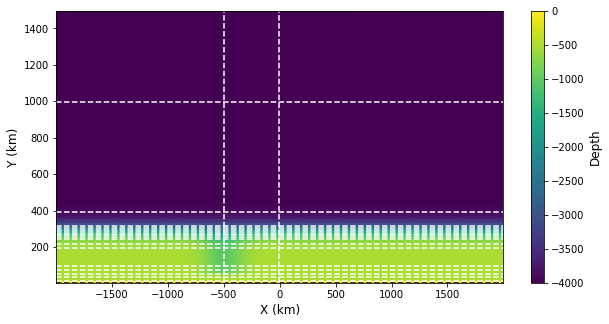

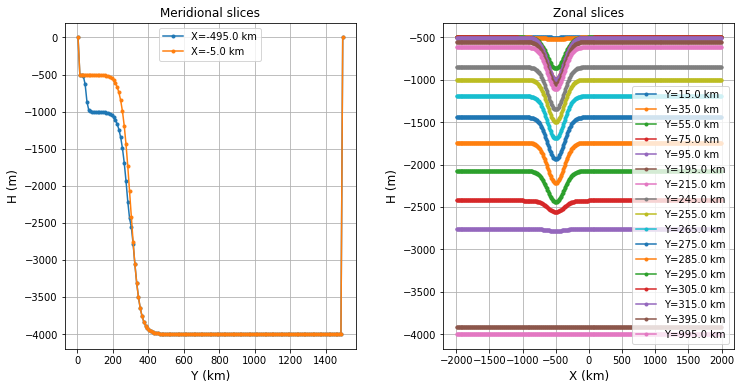

In [132]:
# NOTES: This step uses some custom functions from build_domain. 
# You can use this to add elongated ridges and continent, with cutouts for passages. 
# You'll need to write your code to add more complex features


importlib.reload(build_domain)


# Topographic parameters (find better names)
domain_params['add_SS'] = True # add southern shelf
domain_params['add_SC'] = True # add shelf canyon
domain_params['add_DP'] = False # add drake passage
domain_params['add_ZR'] = False # add zonal ridge
domain_params['add_SAC'] = False # add scotia arc channels

domain_params['SS_H'] = 3500 # shelf height (m)
domain_params['SS_slope_hW'] = 50*mInkm; # Half-width of shelf slope (m)
domain_params['SS_slope_Y'] = 300*mInkm # Meridional position of shelf slope (m)

domain_params['SC_MR'] = -500 # canyon depth (relative to the sea floor) (m)
domain_params['SC_slope_cc'] = 100*mInkm; # steepness of the canyon slopes (half width) (m)
domain_params['SC_X0'] = -500*mInkm # x coord center of canyon
domain_params['SC_dX'] = 250*mInkm # width of canyon
domain_params['SC_Y0'] = 50 #km, start of canyon in y direction
domain_params['SC_Yend'] = 300 #km, end of canyon in y direction
domain_params['SC_ss'] = 10*1000 # curvature of scaling function


# NOTE: to create a drake passage (DP), the code adds a meridional continent then carves out an opening
domain_params['slope_hW'] = domain_params['SS_slope_hW']; # Half-width of shelf slope beyond southern shelf (m)
domain_params['DP_sill_H'] = 1500 # Height of drake passage ridge (m)
domain_params['DP_Y_mid'] = 1500*mInkm # Center latitude of Drake Passage
domain_params['DP_X'] = -1500*mInkm # Longitudinal position of Drake Passage
domain_params['DP_dX'] = 500*mInkm # Longitudinal width of slope of Drake passage ridge (m)
domain_params['DP_dY'] = 500*mInkm # Latitudinal extent of drake passage ridge (m)
domain_params['MR_HoS'] = 100 # height above sea level of meridional ridge (m)

# zonal ridge dimensions
domain_params['ZR_H'] = -100 # Height of zonal ridge (m)
domain_params['ZR_dY'] = 1000*mInkm # zonal length of ZR (m)
domain_params['ZR_dX'] = 150*mInkm # Meridional extent of drake passage ridge (m)
domain_params['ZR_Y_mid'] = (domain_params['DP_Y_mid']
                             - domain_params['DP_dY']/2 
                             - domain_params['ZR_dY']/2)# Center latitude of zonal ridge

domain_params['ZR_X_min'] = domain_params['DP_X']+150*mInkm# Longitudinal start of ZR


# add scotia arc channels
domain_params['SAC_X0'] = [-1000*mInkm] 
domain_params['SAC_dX'] = 200*mInkm 
domain_params['SAC_sill_H'] = 1000



bathy_h = build_domain.add_bathy(run_config, domain_params, grid_params, cmap='viridis',
                                 show_plot=True, x_slices_km=[-495], y_slices_km=[20,40,60,80,100,200,220,250,260,270,280,290,300,310,320,400, 1000])

# # Enforce minimum ocean depth and add walls along northern and southern boundaries
# bathy_h[bathy_h>-100] = 0 # EW NOTE: Not entirely why this done
bathy_h[:, 0] = 0 
bathy_h[:, -1] = 0



# save bathymetry file to input directory
input_fnames = {}
input_fnames['bathyFile'] = 'bathyFile.bin'

bathy_fpath = os.path.join(run_config['input_dir'], input_fnames['bathyFile'])
with open(bathy_fpath, 'wb') as f:
    bathy_h.T.astype('>f8').tofile(f) #<--- need to transpose (mitgcm expects (z,) y, x)
    
plt.show()


In [49]:
    # zonal grid
    dx = domain_params['Lx']/grid_params['Nx'] # x-grid res
    xx = np.arange(grid_params['Nx'] )*dx
    xx = xx-np.mean(xx) # offset so that x=0 is in the center of the domain

    # meridional grid   
    dy = domain_params['Ly']/grid_params['Ny']   # y-grid res
    yy = np.cumsum(dy*np.ones(grid_params['Ny'] )) - dy/2 
    # Y increases with increasing latitude. Also, following Andrew and offseting Y by dy/2)

    # Plotting mesh
    YY, XX = np.meshgrid(yy, xx)
    print("xx:",xx.shape)
    print("yy:",yy.shape)

xx: (400,)
yy: (150,)


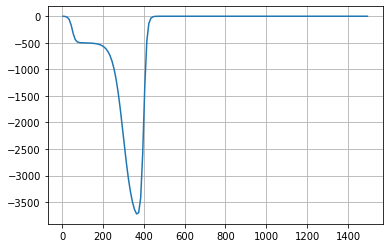

In [111]:
#Testing the attenuation function for what multiplies the h function in the geometry build

Y0 = 50 #km
Yend = 400 #km
ss = 15*1000

scale = -2 + (1+np.tanh((yy-Y0*1000)/ss)/2) + (1-np.tanh((yy-Yend*1000)/ss)/2)

plt.plot(yy/1000,bathy_h[80,:]*scale)
plt.grid()
plt.show()


## Ocean initialization and surface forcing

### Northern Sponge layer

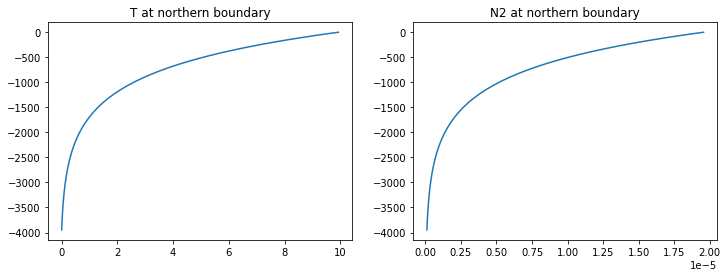

In [23]:
# specify T and S along northern boundary

# Exponential background temperature  
Hscale = 750
mintemp = 0
maxtemp = 10
H = domain_params['H']
temp_north = mintemp + (maxtemp-mintemp)*(np.exp(zz/Hscale)-np.exp(-H/Hscale))/(1-np.exp(-H/Hscale))

# Constant background salinity (currently unused)
sRef = 35;    
sNorth = sRef*np.ones(grid_params['Nr'])

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(temp_north, zz)
plt.title("T at northern boundary")

# compute N2 across meridional transect
plt.subplot(122)
Tz = np.gradient(temp_north, zz, edge_order=2)
N2 = params01['tAlpha']*g*Tz
plt.title("N2 at northern boundary")

plt.plot(N2, zz)
plt.show()

### 3D initial hydrography

In [24]:
# initialize entire domain using northern BCs
grid_size = (grid_params['Nx'], grid_params['Ny'], grid_params['Nr'])
temp_init = np.ones(grid_size)*temp_north
print(temp_init.shape)

# add some random noise
# EW note: not sure why this necessary
temp_noise = 0.1*np.random.rand(*grid_size) 
temp_init += temp_noise-temp_noise.mean()


# save to input file
input_fnames['hydrogThetaFile'] = 'hydrogThetaFile.bin'

temp_fpath = os.path.join(run_config['input_dir'],  'hydrogThetaFile.bin')
with open(temp_fpath, 'wb') as f:
    temp_init.T.astype('>f8').tofile(f) #<--- need to transpose to get Fortran order

# NOTE: need to repeat these steps when evolving salinity

(400, 150, 70)


### Surface winds and heat fluxes

In [25]:
# define horizontal grid
dx = domain_params['Lx']/grid_params['Nx'] # x-grid res
xx = np.arange(grid_params['Nx'] )*dx
xx = xx-np.mean(xx) # offset so that x=0 is in the center of the domain
  
dy = domain_params['Ly']/grid_params['Ny']   # y-grid res
yy = np.cumsum(dy*np.ones(grid_params['Ny'] )) - dy/2 

XX, YY = np.meshgrid(xx, yy)

In [26]:
# tau_east=0.2
# tau_west=0.05
# tau0_y=600
# Qacc=-10
# Qsb=15 #shelf break
# Q0_y=1000

# Ln = domain_params['L_sponge'] # length of northern sponge layer
# Ys = domain_params['SS_slope_Y'] # shelf width 
# Ly = np.round(domain_params['Ly'])
                   
# # NOTES: This code uses spline functions to define zonally uniform surface wind stress and heat fluxes.

# # zonal wind stress
# taux_pts = {}
# taux_pts['yy'] = np.array([0, (tau0_y*1e3)/2, tau0_y*1e3, 830e3, 2190e3, Ly-Ln, Ly])
# taux_pts['values'] = np.array([-tau_west*0, -tau_west*0.99,   0, tau_east*0.375, tau_east*0.375, 0, 0])

# spl = make_interp_spline(taux_pts['yy'], taux_pts['values'], k=3) 
# taux = spl(yy)
# taux[yy>(Ly-Ln)] = 0 # set forcing to zero over sponge layer


# # heat flux out of the ocean
# qflux_pts = {}
# qflux_pts['yy'] = np.array([0, 40e3, 90e3, 380e3, Q0_y*1e3, 1300e3, 2100e3, Ly-Ln, Ly])
# qflux_pts['values'] = np.array([0, Qsb*0.2, Qsb*0.53, Qsb*0.91, 0, Qacc*0.61, Qacc*0.61, 0, 0]) 

# spl = make_interp_spline(qflux_pts['yy'], qflux_pts['values'], k=3)  # type: BSpline
# qflux = spl(yy)
# qflux[yy>(Ly-Ln)] = 0 # set forcing to zero over sponge layer

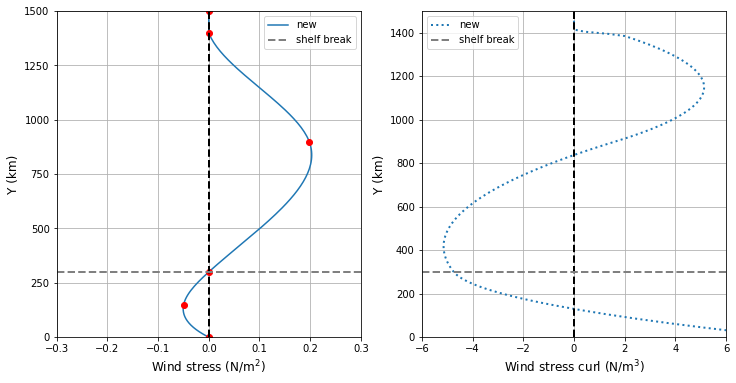

In [27]:
# NOTES: This code uses spline functions to define zonally uniform surface wind stress and heat fluxes.

Ln = domain_params['L_sponge'] # length of northern sponge layer
Ys = domain_params['SS_slope_Y'] # location of shelf break 
Ly = np.round(domain_params['Ly'])

tau_east_max=0.2
tau_west_max=0.05
Y_tau0=Ly*0.2 # latitude where tau=0

# zonal wind stress
taux_pts = {}
taux_pts['yy'] = np.array([0, Y_tau0/2, Y_tau0, Ly*0.6,  Ly-Ln, Ly])
taux_pts['values'] = np.array([-tau_west_max*0, -tau_west_max*0.99, 0, tau_east_max*0.99, 0, 0])

spl = make_interp_spline(taux_pts['yy'], taux_pts['values'], k=3) 
taux = spl(yy)
taux[yy>(Ly-Ln)] = 0 # set forcing to zero over sponge layer


# plot wind profile

fz =12

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0])
plt.plot(taux, yy/1e3, label='new')
plt.plot(taux_pts['values'], taux_pts['yy']/1e3, 'or')
plt.axvline(0, linestyle='--', linewidth=2, color='k')
plt.axhline(Ys/1e3, linestyle='--', linewidth=2, color='0.5', label='shelf break')
plt.xlim(-0.3, 0.3)
plt.yticks(np.arange(0, 2500, 250))
plt.xlabel("Wind stress (N/m$^2$)", fontsize=fz)
plt.ylabel("Y (km)", fontsize=fz)
plt.grid(True)
plt.ylim(0, Ly/1e3)
plt.legend(loc=0, fontsize=fz-2)


# compute and winds stress curl
dtaux_dy = np.gradient(taux, yy, edge_order=2) 

plt.sca(axes[1])
plt.plot(-dtaux_dy*1e7, yy/1e3, ':', linewidth=2, label='new')
plt.xlabel("Wind stress curl (N/m$^3$)", fontsize=fz)
plt.ylabel("Y (km)", fontsize=fz)
plt.xlim(-6, 6)
plt.ylim(0, Ly/1e3)
plt.grid(True)
plt.axvline(0, linestyle='--', linewidth=2, color='k')
plt.axhline(Ys/1e3, linestyle='--', linewidth=2, color='0.5', label='shelf break')
plt.legend(loc=0, fontsize=fz-2)
plt.subplots_adjust(hspace=0.3)
plt.show()

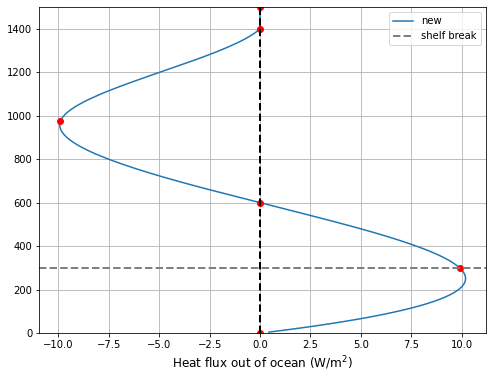

In [28]:
#Q is ocean heat loss.

Q_min=-10 #W/m2 peak surface warming
Q_max=10 #W/m2 peak surface cooling
Y_Q0=Ly*0.4 # latitude where Q = 0 W/m2

# specify heat flux out of the ocean
qflux_pts = {}
qflux_pts['yy'] = np.array([0, Ys, Y_Q0, Ly*0.65, Ly-Ln, Ly])
qflux_pts['values'] = np.array([0, Q_max*0.99, 0, Q_min*0.99, 0, 0]) 

spl = make_interp_spline(qflux_pts['yy'], qflux_pts['values'], k=3)  # type: BSpline
qflux = spl(yy)

qflux[yy>(Ly-Ln)] = 0 # set forcing to zero over sponge layer


#----------plot heat flux profile
plt.figure(figsize=(8, 6))
plt.plot(qflux, yy/1e3, label='new')
plt.plot(qflux_pts['values'], qflux_pts['yy']/1e3, 'or')
plt.axvline(0, linestyle='--', linewidth=2, color='k')
plt.axhline(Ys/1e3, linestyle='--', linewidth=2, color='0.5', label='shelf break')
#plt.xlim(-10, 20)
plt.xlabel("Heat flux out of ocean (W/m$^2$)", fontsize=fz)
plt.grid(True)
plt.ylim(0, Ly/1e3)
plt.legend(loc=0, fontsize=fz-2)
ax1 = plt.gca()
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


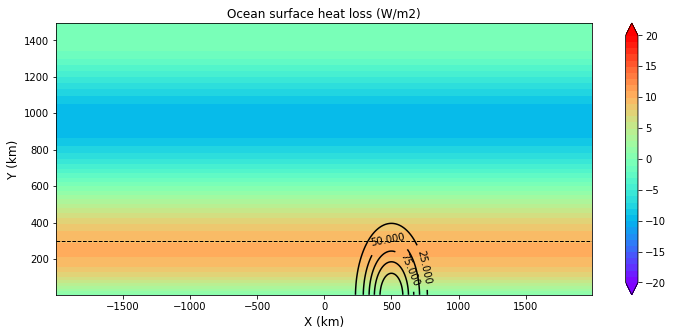

In [29]:
# expand to 2D
taux_2D = np.tile(taux[np.newaxis, :], (len(xx), 1))
qflux_2D = np.tile(qflux[np.newaxis, :], (len(xx), 1))


plt.figure(figsize=(12,5))
vmin, vmax = -20, 20
clvls = np.arange(vmin, vmax+0.1, 1)

plt.contourf(XX/1e3, YY/1e3, qflux_2D.T, clvls, vmin=vmin, vmax=vmax, cmap=plt.cm.rainbow, extend='both')
plt.axhline(Ys/1e3, linestyle='--', linewidth=1, color='k')
plt.xticks(np.arange(-2000, 2001, 500))
ax1.tick_params(axis='both', which='major', labelsize=fz)
plt.ylabel("Y (km)", fontsize=fz)
plt.xlabel("X (km)", fontsize=fz)
plt.title("Ocean surface heat loss (W/m2)", fontsize=fz)
plt.colorbar(extend='both')



#add localized region of intense buoyancy loss
#add_local_Qaabw = True # TODO: move this control somewhere else
Qaabw_max=150 # max cooling; W/m2
aabw_xc = 500e3 # x location of 
aabw_Lc = 200e3 # width of cooling region

# if add_local_Qaabw:
qflux_Ys = Qaabw_max #qflux_new_2D[yi.T].max()
qflux_abbw = qflux_Ys*np.exp(-((XX.T-aabw_xc)/aabw_Lc)**2 - ((YY.T+5e3)/(Ys))**2)
qflux_2D += qflux_abbw
cs = plt.contour(XX/1e3, YY/1e3, qflux_abbw.T, np.arange(25, 201, 25), 
                 colors='k', vmin=vmin, vmax=vmax, extend='both')

plt.clabel(cs, cs.levels, inline=True, fontsize=fz-2)

xidx = np.argmin(np.abs(aabw_xc-xx))
qflux_aabw = qflux_2D[xidx, :]    
plt.show()

In [30]:
# NOTE: we could specify a time component to the surface forcing to create a 3D (x, y, t) file.

In [31]:
# save surface forcing
input_fnames['zonalWindFile'] = 'zonalWindFile.bin'
input_fnames['surfQfile'] = 'surfQFile.bin'

taux_fpath = os.path.join(run_config['input_dir'], input_fnames['zonalWindFile'])
with open(taux_fpath, 'wb') as f:
    taux_2D.T.astype('>f8').tofile(f)

qflux_fpath = os.path.join(run_config['input_dir'], input_fnames['surfQfile'])
with open(qflux_fpath, 'wb') as f:
    qflux_2D.T.astype('>f8').tofile(f)

## Vertical diffusivity 

In [32]:
#TODO: Check that this is actually used by the model

In [33]:
diffKr = params01['diffKrT']*np.ones(grid_size)
kap_deep = 1e-3 # assume diffusivity is maximum at seafloor (m2/s)
H_kap = 300 # e-folding scale for diffusivity
#diffKr[ii, jj, :]
for ii in range(grid_params['Nx']):
    for jj in range(grid_params['Ny']):
        diffKrT_profile = np.exp(-(zz-bathy_h[ii,jj])/H_kap)
        diffKrT_profile[diffKrT_profile>1] = 1                                   
        diffKr[ii, jj, :] = params01['diffKrT'] + diffKrT_profile*kap_deep


In [34]:
plt.figure(figsize=(8, 6))

xloc = xx.mean()
xidx = np.argmin(np.abs(xx-xloc))
ylocs = [yy.mean(), 1500e3]

for yloc in ylocs:
    
    yidx = np.argmin(np.abs(yy-yloc))
    
    p = plt.semilogx(diffKr[xidx, yidx, :], zz, label="x = %s, y = %s" %(xloc/1e3, yloc/1e3))
    
    zidx = np.argmin(np.abs(zz-bathy_h[xidx, yidx]))
    plt.semilogx(diffKr[xidx, yidx, zidx], zz[zidx], 'o', color= p[0].get_color())
    
plt.legend()
plt.xlabel('Vertical diffusivity (m2/s)')
plt.ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

In [35]:
# save diffusivity profile
input_fnames['diffKrFile'] = 'diffKrFile.bin'

diff_fpath = os.path.join(run_config['input_dir'], input_fnames['diffKrFile'])
with open(diff_fpath, 'wb') as f:
    diffKr.T.astype('>f8').tofile(f) # <--- need to transpose   

In [36]:
diffKr.shape

(400, 150, 70)

## Check numeric stability

In [37]:
# compute internal wave speed
N = np.sqrt(N2)

x0 = 0
xidx = np.argmin(np.abs(xx-x0)) #

C_ig = np.zeros(len(yy))
for jj in range(len(yy)):
    for kk in range(len(zz)):
        if zz[kk]>bathy_h[xidx, jj]:
            C_ig[jj] = C_ig[jj] + N[kk]*dz[kk]
        else:
            continue
            
            
R_d = C_ig/(np.pi*np.abs(params01['f0']+params01['beta']*yy))
#print(R_d) 
# Note: R_d here not exactly the same as in matlab calculation but it within a few percent.
# Tz is computed differently here

plt.figure(figsize=(8, 6))
plt.plot(yy[1:-1]/1e3, R_d[1:-1]/1e3)
plt.axhline(run_config['horiz_res_km'], linestyle='--', label='horizontal grid spacing')
plt.legend()
plt.title("First baroclinic Rossby deformation radius (km)")

Text(0.5, 1.0, 'First baroclinic Rossby deformation radius (km)')

In [38]:
# Upper bound for absolute horizontal fluid velocity (m/s)
Umax = 1.0 # Andrew's estimate

# Max gravity wave speed 
cmax = np.max(C_ig)

# Max gravity wave speed using total ocean depth
cgmax = Umax + cmax

# Advective CFL
deltaT_adv = np.min([0.5*dx/cmax,0.5*dy/cmax])

# Gravity wave CFL
deltaT_gw = np.min([0.5*dx/Umax,0.5*dy/Umax])

# CFL time step based on full gravity wave speed
deltaT_fgw = np.min([0.5*dx/cgmax,0.5*dy/cgmax])

deltaT_list = [deltaT_adv, deltaT_gw, deltaT_fgw]

#---Other stability conditions

# Inertial CFL time step (Sf0<=0.5)
deltaT_itl = 0.5/np.abs(params01['f0'])
deltaT_list.append(deltaT_itl)

# Time step constraint based on horizontal diffusion 
deltaT_Ah = 0.5*np.min([dx, dy])**2/(4*params01['viscAh'])  
deltaT_list.append(deltaT_Ah)

# Time step constraint based on vertical diffusion
deltaT_Ar = 0.5*np.min(dz)**2 / (4*params01['viscAr']) 
deltaT_list.append(deltaT_Ar)

# Time step constraint based on biharmonic viscosity 
deltaT_A4 = 0.5*np.min([dx,dy])**4/(32*params01['viscA4'])
deltaT_list.append(deltaT_A4)

# Time step constraint based on horizontal diffusion of temp 
deltaT_KhT = 0.4*np.min([dx,dy])**2/(4*params01['diffKhT'])
deltaT_list.append(deltaT_KhT)

# Time step constraint based on vertical diffusion of temp 
deltaT_KrT = 0.4*np.min(dz)**2 / (4*params01['diffKrT'] )
deltaT_list.append(deltaT_KrT)


deltaT = np.min(deltaT_list)
print("Minimum time step required: %.2f seconds" %deltaT)

deltaT = np.round(deltaT)

Minimum time step required: 694.29 seconds


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


## Numeric solvers and I/O controls

In [39]:
# numeric solver parameters 

params02 = {}
params02['useSRCGSolver'] = True
params02['cg2dMaxIters'] = 1000
params02['cg2dTargetResidual'] = 1e-12

# time stepping parameters 
params03 = {}
# params03['useSRCGSolver'] = True
# params03['cg2dMaxIters'] = 1000
# params03['cg2dTargetResidual'] = 1e-12
params03['alph_AB'] = 1/2
params03['beta_AB'] = 5/12
params03['nIter0'] = 0 #<<-something that could be updated
params03['abEps'] = 0.1

#if run_config['testing']:
    
params03['chkptFreq'] = 0.25*secsInYear
params03['pChkptFreq'] = 5.0*secsInYear #
params03['taveFreq'] = 0.0
params03['dumpFreq'] = 10.0*secsInYear
params03['monitorFreq'] = 1.0*secsInYear


params03['dumpInitAndLast'] = True
params03['pickupStrictlyMatch'] = False

if run_config['periodic_forcing']:
    # under-construction. There are few more things we need to do here.
    raise ValueError
    
#     params03['periodicExternalForcing'] = periodicExternalForcing
#     params03['externForcingPeriod'] = externForcingPeriod
#     params03['externForcingCycle'] = externForcingCycle
    

In [40]:
if run_config['test']:
    nTimeSteps = 5
else:
    nTimeSteps = np.ceil(run_config['nyrs']*secsInYear/deltaT)

simTimeAct = nTimeSteps*deltaT

params03['endTime'] = int(params03['nIter0']*deltaT+simTimeAct)
params03['deltaT'] = np.round(deltaT)

In [41]:
grid_params['Nt'] = nTimeSteps

In [42]:
params03['endTime']

189216324

## Create 'data' files

In [43]:
# NOTE: These steps generate the data text files located int the input directory

In [44]:
# gather params for data file 
params04 = {} #<-- using params04 to be consistent with ordering in Andrew's code
params04['usingCartesianGrid'] = grid_params['usingCartesianGrid']
params04['usingSphericalPolarGrid'] = grid_params['usingSphericalPolarGrid']
params04['delX']  = grid_params['delX']
params04['delY'] = grid_params['delY']
params04['delR'] = dz

In [45]:
# get data fnames param
params05 = {}
for key in input_fnames:
    if key.startswith('relax'):
        continue
    params05[key] = input_fnames[key]

In [46]:
data_params = [params01, params02, params03, params04, params05]
rcf.write_data(run_config, data_params, group_name='data', lf=run_config['lf'])

## Specifiy relaxation of temperature and salinity 

In [47]:
# define some paramters

useRBCtemp = True
useRBCsalt = False # modify if evolving salinity
useRBCuVel = False
useRBCvVel = False
tauRelaxT = 7.0*secsInDay
tauRelaxS = 1.0*secsInDay # modify if evolving salinity
tauRelaxU = 1.0*secsInDay
tauRelaxV = 1.0*secsInDay

rbcs_params01 = {}
rbcs_params01['useRBCtemp'] = useRBCtemp
rbcs_params01['useRBCsalt'] = useRBCsalt
rbcs_params01['useRBCuVel'] = useRBCuVel
rbcs_params01['useRBCvVel'] = useRBCvVel
rbcs_params01['tauRelaxT'] = tauRelaxT
rbcs_params01['tauRelaxS'] = tauRelaxS
rbcs_params01['tauRelaxU'] = tauRelaxU
rbcs_params01['tauRelaxV'] = tauRelaxV

rbcs_params02 = {}

In [48]:
# set relaxation temp
temp_relax = temp_north*np.ones(grid_size)

# set relaxation mask
northRelaxFac = 1
sponge_Y_min = domain_params['Ly'] - domain_params['L_sponge']
sponge_yi = yy>=sponge_Y_min

msk_vals = (1/northRelaxFac)*(yy[sponge_yi]-sponge_Y_min)/domain_params['L_sponge']
# note: this formulation does not guarantee that the relaxation is exactly one at the northern boundary
print(msk_vals)


msk = np.zeros(grid_size)
msk[:, sponge_yi, :] = msk_vals[np.newaxis, :, np.newaxis]

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


In [49]:
# save relaxation (i.e. sponge layer) files
input_fnames['relaxTFile'] = 'sponge_temp.bin'
input_fnames['relaxMaskFile(1)'] = 'rbcs_temp_mask.bin'

fpath = os.path.join(run_config['input_dir'], input_fnames['relaxTFile'])
with open(fpath, 'wb') as f:
    temp_relax.astype('>f8').T.tofile(f) # <--- may need to transpose   
    
fpath = os.path.join(run_config['input_dir'], input_fnames['relaxMaskFile(1)'])
with open(fpath, 'wb') as f:
    np.asfortranarray(msk).astype('>f8').T.tofile(f) # <--- may need to transpose   

In [50]:
rbcs_params01['relaxTFile'] = input_fnames['relaxTFile']
rbcs_params01['relaxMaskFile(1)'] = input_fnames['relaxMaskFile(1)']

In [51]:
data_rbcs_params = [rbcs_params01, rbcs_params02]
rcf.write_data(run_config, data_rbcs_params, group_name='rbcs')

## Set boundary conditions

In [52]:
# NOTE: This is mostly copied verbatim from Andrew's code. I haven't experiment too much with this.

In [53]:
obcs_params01 = {}

# Enables an Orlanski radiation condition at the northern boundary
useOrlanskiNorth = True
OB_Jnorth = grid_params['Ny']*np.ones((grid_params['Nx'])).astype(int)

obcs_params01['useOrlanskiNorth'] = useOrlanskiNorth
obcs_params01['OB_Jnorth'] = OB_Jnorth

# Enforces mass conservation across the northern boundary by adding a
# barotropic inflow/outflow
obcs_params01['useOBCSbalance'] = True
obcs_params01['OBCS_balanceFacN'] = -1.0
obcs_params01['OBCS_balanceFacE'] = 0.0
obcs_params01['OBCS_balanceFacS'] = 0.0
obcs_params01['OBCS_balanceFacW'] = 0.0

In [54]:
### Velocity averaging time scale - must be larger than deltaT.
### The Orlanski radiation condition computes the characteristic velocity
### at the boundary by averaging the spatial derivative normal to the 
### boundary divided by the time step over this period.
### At the moment we're using the magic engineering factor of 3.
cvelTimeScale = 3*deltaT
#Max dimensionless CFL for Adams-Basthforth 2nd-order method
CMAX = 0.45

obcs_params02 = {}
obcs_params02['cvelTimeScale'] = cvelTimeScale
obcs_params02['CMAX'] = CMAX

In [55]:
obcs_params = [obcs_params01, obcs_params02]
rcf.write_data(run_config, obcs_params, group_name='obcs')

## Set layers package

In [56]:
# NOTE: the layers package is useful for computing the overturning streamfunction

In [57]:
layers_params01 = {}

### Number of fields for which to calculate layer fluxes
layers_maxNum = 1

### Specify potential temperature
layers_name = 'TH'

### Potential temperature bounds for layers  
layers_bounds = np.hstack([np.arange(-1, 1, 0.05), np.arange(1, 3, 0.2), np.arange(3, 7.2, 0.3),
                           np.arange(7.4, 9, 0.2), np.arange(9, 12.001, 0.1)])
# layers_bounds = np.hstack([np.arange(-1, 1, 0.05), np.arange(1, 3, 0.1), np.arange(3, 9, 0.25),
#                            np.arange(9, 12.001, 0.5)])
                           
### Reference level for calculation of potential density
layers_krho = 1    

### If set true, the GM bolus velocity is added to the calculation
if run_config['use_GMRedi']:
    layers_bolus = True
else:
    layers_bolus = False

### Layers
layers_params01['layers_bounds'] = layers_bounds
layers_params01['layers_krho'] = layers_krho
layers_params01['layers_name'] = layers_name
layers_params01['layers_bolus'] = layers_bolus

In [58]:
layers_params = [layers_params01]
rcf.write_data(run_config, layers_params, group_name='layers')

In [59]:
# create createLAYERSSIZEh
Nlayers = len(layers_params01['layers_bounds'])-1
rcf.createLAYERSSIZEh(run_config, Nlayers)

## Specify GM Redi

In [60]:
# NOTE: run_config['use_GMRedi']=False, the model will ignore all of this

gmredi_params01 = {}
gmredi_params01['GM_isopycK'] = 1000.0
gmredi_params01['GM_background_K'] = 1000.0
gmredi_params01['GM_maxSlope'] = 0.025
gmredi_params01['GM_taper_scheme'] = 'dm95'
gmredi_params01['GM_Scrit'] = 0.025
gmredi_params01['GM_Sd'] = 0.0025


In [61]:
gmredi_params = [gmredi_params01]
rcf.write_data(run_config, gmredi_params, group_name='gmredi')

In [62]:
#debug

## Specify Diagnostics

In [63]:
# Here we specify variables that should saved (i.e., written to disk) at various time intervals

# adjust output frequency
if run_config['test']:
    run_config['inst_freq'] = 1 # multiples of timestep
    run_config['tavg_freq'] = 5 # multiples of timestep
    
else:
    run_config['inst_freq'] = 1 # multiples of year
    run_config['tavg_freq'] = 5 # multiples of year


#---------specify time averaged fields------#
# NOTE: many more options available see mitgcm docs
diag_fields_avg = ['UVEL', 'VVEL', 'WVEL','UVELTH', 'VVELTH','WVELTH','THETA']

# diag_fields_avg = ['UVEL', 'VVEL', 'WVEL', 'UVELSQ', 'VVELSQ', 'WVELSQ',
#                   'UVELTH', 'VVELTH', 'WVELTH', 'THETA', 'THETASQ',
#                   'PHIHYD', 'LaUH1TH', 'LaVH1TH', 'LaHw1TH','LaHs1TH']

numdiags_avg = len(diag_fields_avg)
diag_phase_avg = 0.0

if run_config['test'] == True:
    diag_freq_inst = -run_config['inst_freq']*deltaT # negative values indicate snapshots at given interval
    diag_freq_avg = run_config['tavg_freq']*deltaT # positive values indicate time average over specified interval
else:
    diag_freq_inst = -run_config['inst_freq']*secsInYear 
    diag_freq_avg = run_config['tavg_freq']*secsInYear
    
    
diag_params01 = {}
diag_params01['diag_mnc'] = False #<---you would need to modify this if you want netcdf output

for ii in range(numdiags_avg):  
    n = ii+1
    diag_params01['fields(1,%s)'%n] = diag_fields_avg[ii]
    diag_params01['fileName(%s)'%n] = diag_fields_avg[ii]
    diag_params01['frequency(%s)'%n] = diag_freq_avg
    diag_params01['timePhase(%s)'%n] = diag_phase_avg

    
#--------specify instanteous fields (i.e. snapshots)--------#
diag_fields_inst = ['UVEL', 'VVEL', 'THETA']
numdiags_inst = len(diag_fields_inst)
diag_phase_inst = 0.0

for ii in range(numdiags_inst):
    n = numdiags_avg+ii+1
    diag_params01['fields(1,%s)'%n] = diag_fields_inst[ii]
    diag_params01['fileName(%s)'%n] = diag_fields_inst[ii] + '_inst'
    diag_params01['frequency(%s)'%n] = diag_freq_inst
    diag_params01['timePhase(%s)'%n] = diag_phase_inst
    
print(diag_params01)
Ndiags = n

{'diag_mnc': False, 'fields(1,1)': 'UVEL', 'fileName(1)': 'UVEL', 'frequency(1)': 157680000, 'timePhase(1)': 0.0, 'fields(1,2)': 'VVEL', 'fileName(2)': 'VVEL', 'frequency(2)': 157680000, 'timePhase(2)': 0.0, 'fields(1,3)': 'WVEL', 'fileName(3)': 'WVEL', 'frequency(3)': 157680000, 'timePhase(3)': 0.0, 'fields(1,4)': 'UVELTH', 'fileName(4)': 'UVELTH', 'frequency(4)': 157680000, 'timePhase(4)': 0.0, 'fields(1,5)': 'VVELTH', 'fileName(5)': 'VVELTH', 'frequency(5)': 157680000, 'timePhase(5)': 0.0, 'fields(1,6)': 'WVELTH', 'fileName(6)': 'WVELTH', 'frequency(6)': 157680000, 'timePhase(6)': 0.0, 'fields(1,7)': 'THETA', 'fileName(7)': 'THETA', 'frequency(7)': 157680000, 'timePhase(7)': 0.0, 'fields(1,8)': 'UVEL', 'fileName(8)': 'UVEL_inst', 'frequency(8)': -31536000, 'timePhase(8)': 0.0, 'fields(1,9)': 'VVEL', 'fileName(9)': 'VVEL_inst', 'frequency(9)': -31536000, 'timePhase(9)': 0.0, 'fields(1,10)': 'THETA', 'fileName(10)': 'THETA_inst', 'frequency(10)': -31536000, 'timePhase(10)': 0.0}


In [64]:
diag_params02={}
diag_params = [diag_params01, diag_params02]
rcf.write_data(run_config, diag_params, group_name='diagnostics')

In [65]:
## create DIAGNOSTICS_SIZE.h
Nlevels = np.max([grid_params['Nr'], Nlayers])
rcf.createDIAGSIZEh(run_config, Ndiags, Nlevels)

## Generate eedata and SIZEh files

In [66]:
# create eedata
rcf.create_eedata(run_config, grid_params['nTx'], grid_params['nTy'])

In [67]:
# generate size.h file
rcf.createSIZEh(run_config, grid_params)

## update GMRedi package 

if necessary...

In [68]:
if run_config['use_GMRedi']:
            
        
    new_data_pkg = ['# Packages\n', ' &PACKAGES\n', ' useDiagnostics=.TRUE.,\n',
                    ' useRBCS=.TRUE.,\n', ' useOBCS=.FALSE.,\n', ' useKPP=.TRUE.,\n',
                    ' useLayers=.TRUE.,\n', ' useBBL=.FALSE.,\n', ' useGMREDI=.TRUE.,\n',
                    ' /']

    new_package_config = ['gfd\n', 'diagnostics\n', 'timeave\n', 'rbcs\n',
                          'kpp\n', 'layers\n', 'gmredi']
    # back up old files
    input_fpath = os.path.join(run_config['run_dir'], 'code')
    src_fpath1 = os.path.join(input_fpath, 'data.pkg')
    shutil.copy2(src_fpath, src_fpath+'.old')
    
    src_fpath2 = os.path.join(code_fpath, 'packages.conf')
    shutil.copy2(src_fpath, src_fpath+'.old')
    
    # save new files
    with open(src_fpath1, 'w') as f:
        text = "".join(new_data_pkg)
        f.writelines(text)
        
    with open(src_fpath2, 'w') as f:
        text = "".join(new_package_config)
        f.writelines(text)   

## Estimate wall clock time

In [69]:
# Computation time (in hours) per gridpoint (in space and time) assigned to each processor.
# NOTE: each processor works on a tile not the entire grid
#alpha = 4.59e-10 #tested on the Sherlock for 250 cpus (needs to reevaluated on new machines)


### ---Notes from Andrew S.----#
### Estimated total computation time in hours (assumes one tile per nTimeSteps
### processor). 

### This tends to overestimate the computation time when OLx is
### comparable to sNx or OLy is comparable to sNy.
# comptime = alpha*(sNx+2*OLx)*(sNy+2*OLy)*Nr*Nt  

### This seems to provide a decent estimate when OLx is
### comparable to sNx or OLy is comparable to sNy; 'ghost' gridpoints
### require perhaps half as much processing as 'real' gridpoints.


# comptime_hrs = alpha*((grid_params['sNx']+grid_params['OLx'])*
#                   (grid_params['sNy']+grid_params['OLy'])*grid_params['Nr']*grid_params['Nt'])

wall_mins_per_sim_yr = 80 #

sim_yrs = nTimeSteps*deltaT/secsInYear

comptime_hrs = sim_yrs*wall_mins_per_sim_yr/60
  
print("Estimate completion time: %.2f hrs" %comptime_hrs)
print("Estimate completion time: %.2f mins" %(comptime_hrs*60))

Estimate completion time: 8.00 hrs
Estimate completion time: 480.00 mins


## Cluster configuraton

In [70]:
# Sherlock (Stanford)


cluster_params = {}
cluster_params['cluster_name'] = 'sherlock'
cluster_params['opt_file'] = 'darwin_amd64_gfortran_v2' #<-- may need to update this at some point
cluster_params['open_mpi_ver'] = '4.0.3' #'4.0.3' 4.1.2'
cluster_params['mpi_inc_dir'] = '/share/software/user/open/openmpi/%s/include' %cluster_params['open_mpi_ver'] 
cluster_params['netcdf_dir'] = '/share/software/user/open/netcdf/4.4.1.1'
cluster_params['use_mpi'] = True
cluster_params['use_pbs'] = True

cluster_params['username'] = SUNet_ID
cluster_params['email'] = email
cluster_params['login_rootname'] = 'login.sherlock.stanford.edu'
cluster_params['mitgcm_code_dir'] = MITgcm_code_dir
cluster_params['exps_dir'] = run_config['run_dir']
cluster_params['tools_dir'] = os.path.join(cluster_params['mitgcm_code_dir'], 'tools')
cluster_params['run_dir'] = os.path.join(cluster_params['exps_dir'], run_config['run_name'])
cluster_params['cpus_per_node'] = 20 # if

In [71]:
run_config['run_dir']

'/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments/shelf_channel_500_250_10km'

## Generate shell scripts to run model

### Create shell script for building mitgcm

In [72]:
if run_config['use_MPI']:
    mpi_str = '-mpi '
else:
    mpi_str = ''
    
    
#opt_fpath = os.path.join(cluster_params['tools_dir'], 'build_options/', cluster_params['opt_file'])
opt_fpath = os.path.join(group_home_dir, 'shared/build_options', cluster_params['opt_file'])
    
gen2make_fpath = os.path.join(cluster_params['tools_dir'], 'genmake2')


buildcommands = ['rm my_opt_file\n', 'module load openmpi/%s\n'%cluster_params['open_mpi_ver'] , 
                 'export MITGCMROOT="%s"\n'%cluster_params['mitgcm_code_dir'],
                 'export MPI_INC_DIR=%s\n'%cluster_params['mpi_inc_dir'],
                 'ln -s %s my_opt_file \n'%opt_fpath,
                 '%s %s -rootdir=$MITGCMROOT -mods=../code -of=my_opt_file\n'%(gen2make_fpath, mpi_str),
                 'make depend\n','make --always-make -j 2\n']


#print("".join(buildcommands))
build_fpath = os.path.join(run_config['run_dir'], 'build/')
with open(os.path.join(build_fpath, 'build.sh'), 'w') as f:
        text = "".join(buildcommands)
        f.writelines(text)
        
        
print(text)

rm my_opt_file
module load openmpi/4.0.3
export MITGCMROOT="/home/groups/earlew/shared/mitgcm_releases/MITgcm-checkpoint67g"
export MPI_INC_DIR=/share/software/user/open/openmpi/4.0.3/include
ln -s /home/groups/earlew/shared/build_options/darwin_amd64_gfortran_v2 my_opt_file 
/home/groups/earlew/shared/mitgcm_releases/MITgcm-checkpoint67g/tools/genmake2 -mpi  -rootdir=$MITGCMROOT -mods=../code -of=my_opt_file
make depend
make --always-make -j 2



### Create SBATCH script for submitting jobs to the cluster

In [73]:
# create SBATCH file for submitting the job to the cluster
rcf.createSBATCHfile_Sherlock(run_config, cluster_params, walltime_hrs=1.2*comptime_hrs, email=email,
                                part='serc', use_mpirun=False, mem_GB=1, specify_nodes=True)

--------------------

#!/bin/bash 
#SBATCH -J shelf_channel_500_250_10km # job name 
#SBATCH -o output_%j.txt # output and error file name (%j expands to jobID)
#SBATCH -n 250   #total number of mpi tasks requested
#SBATCH --nodes=13   #total number of nodes requested
#SBATCH --mem-per-cpu=1G
#SBATCH -p serc
#SBATCH -t 09:36:00 # run time (hh:mm:ss)
#SBATCH --mail-user=ejdawson@stanford.edu
#SBATCH --mail-type=begin  # email me when the job starts
#SBATCH --mail-type=end  # email me when the job finishes

module load netcdf
module load openmpi/4.0.3
#module load openmpi
srun ./mitgcmuv


In [74]:
# create wrapper function for the SBATCH script
ncpus = grid_params['nPy']*grid_params['nPx']
sbatch_cmnds = ['ln -s ../input/* ./ \n',  'ln -s ../build/mitgcmuv \n', 
                'module load openmpi/%s\n'%cluster_params['open_mpi_ver'] ]
 
sbatch_cmnds.append('sbatch run_mitgcm > output.txt \n')


print("".join(sbatch_cmnds))
results_dir = os.path.join(run_config['run_dir'], 'results/')
with open(os.path.join(results_dir, 'run.sh'), 'w') as f:
        text = "".join(sbatch_cmnds)
        f.writelines(text)

ln -s ../input/* ./ 
ln -s ../build/mitgcmuv 
module load openmpi/4.0.3
sbatch run_mitgcm > output.txt 



## Consolidate and save run parameters

In [75]:
# combine
run_config['domain_params'] = domain_params
run_config['grid_params'] = grid_params
run_config['cluster_params'] = cluster_params

In [76]:
# add params required by mitgcm
run_config['mitgcm_params'] = {}
run_config['mitgcm_params']['data'] = data_params
run_config['mitgcm_params']['data_rbcs'] = data_rbcs_params
run_config['mitgcm_params']['data_obcs'] = obcs_params
run_config['mitgcm_params']['data_layers'] = layers_params
run_config['mitgcm_params']['data_gm'] = gmredi_params
run_config['mitgcm_params']['data_diagnostics'] = diag_params

In [77]:
run_config.keys()

dict_keys(['ncpus_xy', 'run_name', 'nyrs', 'test', 'horiz_res_km', 'Lx_km', 'Ly_km', 'evolve_salt', 'use_GMRedi', 'periodic_forcing', 'use_MPI', 'lf', 'exps_dir', 'run_dir', 'build_dir', 'code_dir', 'input_dir', 'results_dir', 'inst_freq', 'tavg_freq', 'domain_params', 'grid_params', 'cluster_params', 'mitgcm_params'])

In [78]:
run_config

params_fpath = os.path.join(run_config['input_dir'], 'params.p')
with open(params_fpath, 'wb') as f:
    pickle.dump(run_config, f)

In [79]:
run_config

{'Lx_km': 4000,
 'Ly_km': 1500,
 'build_dir': '/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments/shelf_channel_500_250_10km/build',
 'cluster_params': {'cluster_name': 'sherlock',
  'cpus_per_node': 20,
  'email': 'ejdawson@stanford.edu',
  'exps_dir': '/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments/shelf_channel_500_250_10km',
  'login_rootname': 'login.sherlock.stanford.edu',
  'mitgcm_code_dir': '/home/groups/earlew/shared/mitgcm_releases/MITgcm-checkpoint67g',
  'mpi_inc_dir': '/share/software/user/open/openmpi/4.0.3/include',
  'netcdf_dir': '/share/software/user/open/netcdf/4.4.1.1',
  'open_mpi_ver': '4.0.3',
  'opt_file': 'darwin_amd64_gfortran_v2',
  'run_dir': '/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments/shelf_channel_500_250_10km/shelf_channel_500_250_10km',
  'tools_dir': '/home/groups/earlew/shared/mitgcm_releases/MITgcm-checkpoint67g/tools',
  'use_mpi': True,
  'use_pbs': True,
  'username': 'ejda

In [80]:
run_config['exps_dir']

'/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments'

In [81]:
run_config['build_dir']

'/scratch/groups/earlew/ejdawson/research/modeling/MITgcm_PG/experiments/shelf_channel_500_250_10km/build'

## Next steps

Once you've successfully set up the model experiment, you will need to do the following:

+ Navigate to the build directory and compile the code (i.e., `sh build.sh`). This may take a couple minutes and will generates lots of new files in the build directory. The key file is the `mitgcmuv` executable.



+ Next, go to the results directory and submit the job to Sherlock queue (`sh run.sh`). It is recommended that you do this from a login node. This should generate a unique output_xxx file, which logs error messages for each run. You will get emails when the job is released from the queue and when it is completed. Test runs normally take a few minutes. A successful run will generate dozens of output files, including data files like `THETA_inst_000000.data`. 


To check if the job is running:   `squeue | grep ejdawson`
